In [15]:
from scipy.ndimage import sobel
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

In [41]:
x = torch.from_numpy(np.linspace(-1, 1, 128))
signal =  x**3
signal.shape

torch.Size([128])

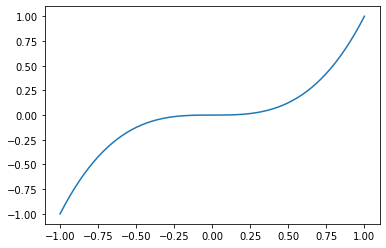

In [42]:
plt.plot(x, signal)

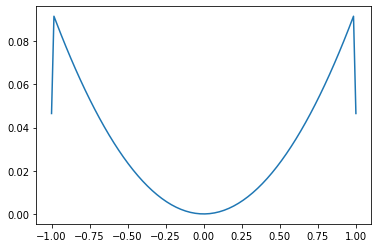

In [43]:
d1 = sobel(signal)
plt.plot(x, d1)

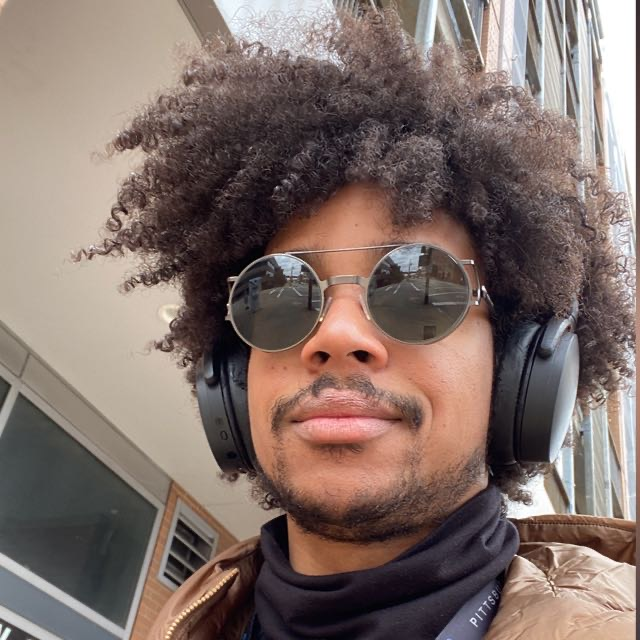

In [22]:
img = Image.open('E:\Workspace\impa\mrnet\img\hallpaz.jpg')
img

In [44]:
signal2 = torch.from_numpy(np.array(img)).permute((2, 0, 1)) / 255
signal2.shape

torch.Size([3, 640, 640])

In [45]:
d1x = sobel(signal2, axis=1)
d1x.shape

(3, 640, 640)

In [46]:
np.min(d1x), np.max(d1x)

TypeError: min(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

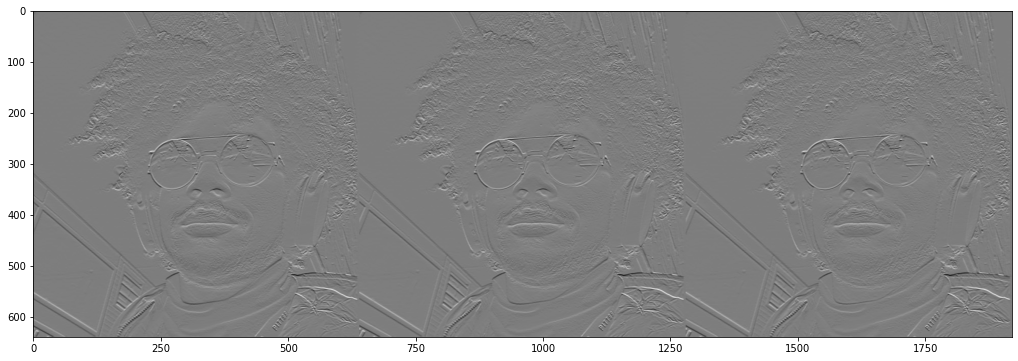

In [35]:
plt.figure(figsize=(18, 6))
plt.imshow(np.hstack([d1x[i, ...] for i in range(len(d1x))]), cmap='gray')

In [37]:
d1y = sobel(signal2, axis=2)
d1y.shape, np.min(d1y), np.max(d1y)

((3, 640, 640), -13.96078431372549, 12.43921568627451)

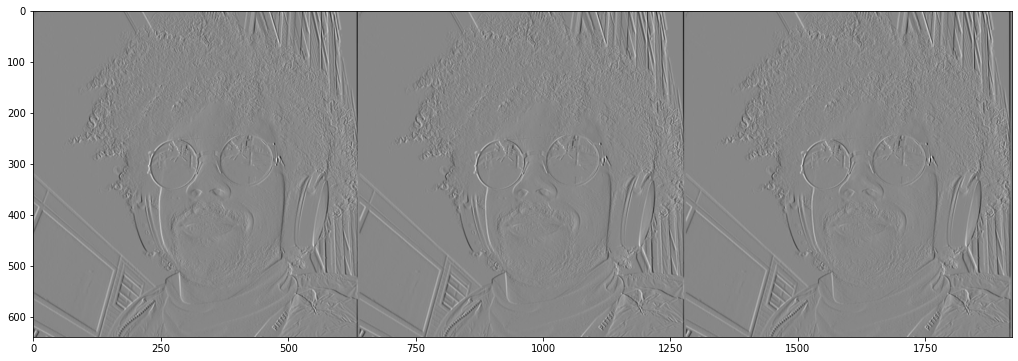

In [38]:
plt.figure(figsize=(18, 6))
plt.imshow(np.hstack([d1y[i, ...] for i in range(len(d1y))]), cmap='gray')

In [39]:
mag = np.sqrt(d1x**2 + d1y**2)
mag.shape, np.min(mag), np.max(mag)

((3, 640, 640), 0.0, 13.974181718788655)

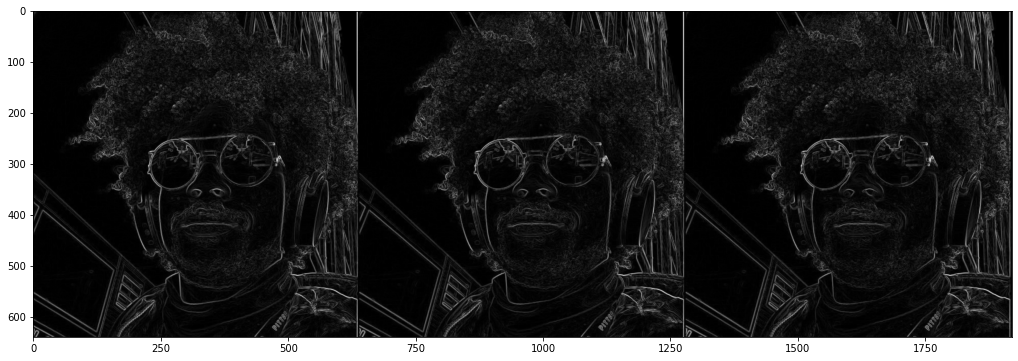

In [40]:
plt.figure(figsize=(18, 6))
plt.imshow(np.hstack([mag[i, ...] for i in range(len(mag))]), cmap='gray')

In [50]:
derivatives = torch.stack(
    [torch.from_numpy(d1x), torch.from_numpy(d1y)], dim=-1)
derivatives.shape

torch.Size([3, 640, 640, 2])

In [56]:
import os
from pathlib import Path

from logs.wandblogger import WandBLogger2D
from training.trainer import MRTrainer
from datasets.sampler import make_grid_coords
from networks.mrnet import MRFactory
from datasets.pyramids import create_MR_structure
import yaml
from yaml.loader import SafeLoader
import os

os.environ["WANDB_NOTEBOOK_NAME"] = "train-wb.ipynb"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
BASE_DIR = Path('.').absolute().parents[0]
IMAGE_PATH = BASE_DIR.joinpath('img')
MODEL_PATH = BASE_DIR.joinpath('models')

project_name = "optim-init"
#-- hyperparameters in configs --#
config_file = '../configs/config_base_m_net.yml'
with open(config_file) as f:
    hyper = yaml.load(f, Loader=SafeLoader)
    if isinstance(hyper['batch_size'], str):
        hyper['batch_size'] = eval(hyper['batch_size'])
    print(hyper)
imgpath = os.path.join(IMAGE_PATH, hyper['image_name'])
maskpath = None

{'model': 'M', 'positive_freqs': False, 'in_features': 2, 'out_features': 3, 'hidden_layers': 1, 'hidden_features': [[128, 64], [32, 64], [128, 96], 192], 'bias': True, 'max_stages': 1, 'period': 2, 'domain': [-1, 1], 'omega_0': [64, 3, 8, 4, 6, 8, 16, 32], 'hidden_omega_0': [30, 30, 30, 30, 30, 30, 30], 'superposition_w0': False, 'sampling_scheme': 'regular', 'decimation': True, 'filter': 'gauss', 'attributes': ['d0'], 'loss_function': 'mse', 'opt_method': 'Adam', 'lr': 0.0005, 'loss_tol': 1e-12, 'diff_tol': 1e-09, 'max_epochs_per_stage': [2000, 1000, 600, 400, 400, 400, 400], 'batch_size': 262144, 'image_name': 'periodic.png', 'width': 512, 'height': 512, 'channels': 3, 'device': 'cuda', 'eval_device': 'cpu', 'save_format': 'general', 'visualize_grad': True, 'extrapolate': [-2, 2]}


In [57]:
mrmodel = MRFactory.from_dict(hyper)

In [61]:
coords = make_grid_coords(128, *hyper['domain'], 2)
outdict = mrmodel(coords)

In [68]:
def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [73]:
grads = gradient(outdict['model_out'], outdict['model_in'])
grads.shape, outdict['model_out'].shape, outdict['model_in'].shape

(torch.Size([16384, 2]), torch.Size([16384, 3]), torch.Size([16384, 2]))

In [76]:
grads[0:4, 0], grads[0:4, 1]

(tensor([ 7.5152, -2.1738,  7.2013, -5.7389], grad_fn=<SelectBackward0>),
 tensor([ -0.9069,   0.5956, -11.8216,   6.8547], grad_fn=<SelectBackward0>))

In [78]:
gradsr = gradient(outdict['model_out'][:, 0:1], outdict['model_in'])
gradsr[0:4, 0], gradsr[0:4, 1]

(tensor([-3.9562,  0.1030,  1.4020, -0.3481], grad_fn=<SelectBackward0>),
 tensor([-1.7162, -2.1252, -2.3675, -2.7725], grad_fn=<SelectBackward0>))

In [79]:
gradsg = gradient(outdict['model_out'][:, 1:2], outdict['model_in'])
gradsg[0:4, 0], gradsg[0:4, 1]

(tensor([ 8.2330,  3.5901, -0.3640, -2.5582], grad_fn=<SelectBackward0>),
 tensor([ 3.1030,  0.8129, -5.4773,  4.5270], grad_fn=<SelectBackward0>))

In [80]:
gradsb = gradient(outdict['model_out'][:, 2:3], outdict['model_in'])
gradsb[0:4, 0], gradsb[0:4, 1]

(tensor([ 3.2384, -5.8669,  6.1632, -2.8326], grad_fn=<SelectBackward0>),
 tensor([-2.2938,  1.9079, -3.9768,  5.1001], grad_fn=<SelectBackward0>))

In [81]:
gradsr[0:4, 0] + gradsg[0:4, 0] + gradsb[0:4, 0], gradsr[0:4, 1] + gradsg[0:4, 1] + gradsb[0:4, 1]

(tensor([ 7.5152, -2.1738,  7.2012, -5.7389], grad_fn=<AddBackward0>),
 tensor([ -0.9069,   0.5956, -11.8216,   6.8547], grad_fn=<AddBackward0>))